# Two‑Stage Blink Classifier
Skeleton notebook created 2025-05-15 14:07:12.703580

### Imports

In [1]:
import numpy as np, pandas as pd, torch
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
import snntorch as snn
from snntorch import utils
from sklearn.metrics import classification_report
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torch
import torchdata
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
print("device =", device)

import random

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

import brevitas
import brevitas.nn as qnn


device = cpu


### Parameters

In [2]:
import numpy as np, pandas as pd, torch, snntorch as snn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from snntorch import surrogate, utils
from sklearn.metrics import classification_report
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CSV              = "./data/DM_OUT_S14_50s-90s.csv"
SAMPLING_RATE_HZ = 256
WIN_MS           = 200                               # 200-ms windows
WIN              = int(WIN_MS/1000 * SAMPLING_RATE_HZ) #51.2 samples
STRIDE           = WIN//4                            # 75 % overlap
THR_VOLT         = 1.7                               # spike threshold
BATCH            = 32
EPOCHS           = 40
LR               = 1e-4
THRESH_PROB      = 0.30                              # decision cut-off

In [3]:
import matplotlib.pyplot as plt
import numpy as np

start = 0
multiplier = 1
end = 100 * multiplier
t = np.arange(endpoint)/256     # first 2 000 samples
df = pd.read_csv(CSV)
plt.plot(t, df["/spk_up Y"].iloc[:endpoint], label="up")
plt.plot(t, df["/spk_down Y"].iloc[:endpoint], label="down")
plt.plot(t, df["/label Y"].iloc[:endpoint], label="label")
plt.legend(); plt.show()
thr = 1.7
# positive spikes  → likely *hard*
spk_up_pos   = (df["/spk_up Y"]   >  thr).astype(np.float32)
spk_down_neg = (df["/spk_down Y"] > thr).astype(np.float32)
# everything else is zero
win_hard = spk_up_pos[start:end].any()        # 1 if hard blink
win_soft = spk_down_neg[start:end].any()      # 1 if soft blink
blink = [(spk_up_pos[s:s+WIN_MS].any() or spk_down_neg[s:s+WIN_MS].any()) 
		 for s in range(0, len(spk_up_pos) - WIN_MS, STRIDE)]
cnt_hard = [spk_up_pos[s:s+WIN_MS].sum() for s in range(0, len(spk_up_pos) - WIN_MS, STRIDE)]
cnt_soft = [spk_down_neg[s:s+WIN_MS].sum() for s in range(0, len(spk_down_neg) - WIN_MS, STRIDE)]

print("mean hard-spikes (blink windows):", np.mean([c for c, t in zip(cnt_hard, blink) if t]))
print("mean hard-spikes (no-blink)    :", np.mean([c for c, t in zip(cnt_hard, blink) if not t]))

NameError: name 'endpoint' is not defined

### Window Extraction

In [ ]:
df  = pd.read_csv(CSV)
up  = (df["/spk_up Y"].abs()   > THR_VOLT).astype(np.float32).to_numpy()
dn  = (df["/spk_down Y"].abs() > THR_VOLT).astype(np.float32).to_numpy()
lab = df["/label Y"].to_numpy()                 # 0 | 1 | 2
# LABEL_MARGIN = int(0.1 * SAMPLING_RATE_HZ)
LABEL_MARGIN = WIN
X, y = [], []
for s in range(0, len(df)-WIN+1, STRIDE):
    e = s + WIN

    # spike raster [T,2]  (0/1)
    x_win = np.stack([up[s:e], dn[s:e]], axis=1)
    
    # --------------------------- target  ---------------------------
    # extend slice by ±LABEL_MARGIN but stay in bounds
    ls = max(0, s - LABEL_MARGIN)
    le = min(len(df), e + LABEL_MARGIN)
    lab_max = lab[ls:le].max()
    if   lab_max == 2: y.append([1, 0])      # soft
    elif lab_max == 1: y.append([0, 1])      # hard
    else:              y.append([0, 0])      # no-blink

    X.append(x_win.astype(np.float32))
    # --------------------------- target  ---------------------------
X = torch.tensor(np.stack(X))         # [N,T,2]
y = torch.tensor(np.stack(y))         # [N,2]
print("windows:", len(X),
      "| soft:", int(y[:,0].sum()),
      "| hard:", int(y[:,1].sum()))

[0.0, 0.0] 2
[0.0, 0.0] 2
[0.0, 0.0] 2
[0.0, 0.0] 2
[2.0, 0.0] 2
[2.0, 0.0] 2
[2.0, 0.0] 2
[2.0, 0.0] 2
[0.0, 0.0] 2
[0.0, 0.0] 2
[0.0, 0.0] 2
[0.0, 0.0] 2
[0.0, 0.0] 2
[0.0, 0.0] 2
[0.0, 0.0] 2
[0.0, 0.0] 2
[0.0, 0.0] 2
[0.0, 0.0] 2
[0.0, 0.0] 2
[0.0, 1.0] 2
[0.0, 1.0] 2
[0.0, 1.0] 2
[0.0, 1.0] 2
[0.0, 0.0] 2
[0.0, 0.0] 0
[0.0, 0.0] 0
[0.0, 0.0] 0
[0.0, 0.0] 0
[0.0, 0.0] 0
[1.0, 0.0] 0
[1.0, 0.0] 0
[1.0, 2.0] 0
[1.0, 2.0] 0
[0.0, 2.0] 0
[0.0, 2.0] 0
[0.0, 1.0] 0
[0.0, 0.0] 0
[0.0, 0.0] 2
[0.0, 0.0] 2
[0.0, 0.0] 2
[0.0, 0.0] 1
[0.0, 0.0] 1
[0.0, 0.0] 1
[3.0, 0.0] 1
[5.0, 0.0] 1
[5.0, 0.0] 1
[5.0, 2.0] 1
[3.0, 6.0] 1
[0.0, 8.0] 1
[0.0, 9.0] 1
[0.0, 8.0] 1
[0.0, 4.0] 1
[0.0, 1.0] 1
[2.0, 0.0] 2
[2.0, 0.0] 2
[2.0, 0.0] 2
[3.0, 0.0] 2
[1.0, 0.0] 2
[1.0, 0.0] 2
[1.0, 0.0] 2
[0.0, 0.0] 2
[0.0, 0.0] 2
[0.0, 0.0] 2
[0.0, 0.0] 2
[0.0, 0.0] 2
[0.0, 0.0] 2
[0.0, 0.0] 2
[0.0, 0.0] 2
[0.0, 1.0] 2
[0.0, 1.0] 2
[0.0, 1.0] 2
[0.0, 1.0] 2
[0.0, 1.0] 2
[0.0, 0.0] 2
[0.0, 0.0] 2
[0.0, 0.0] 2
[0.0, 1.0] 2

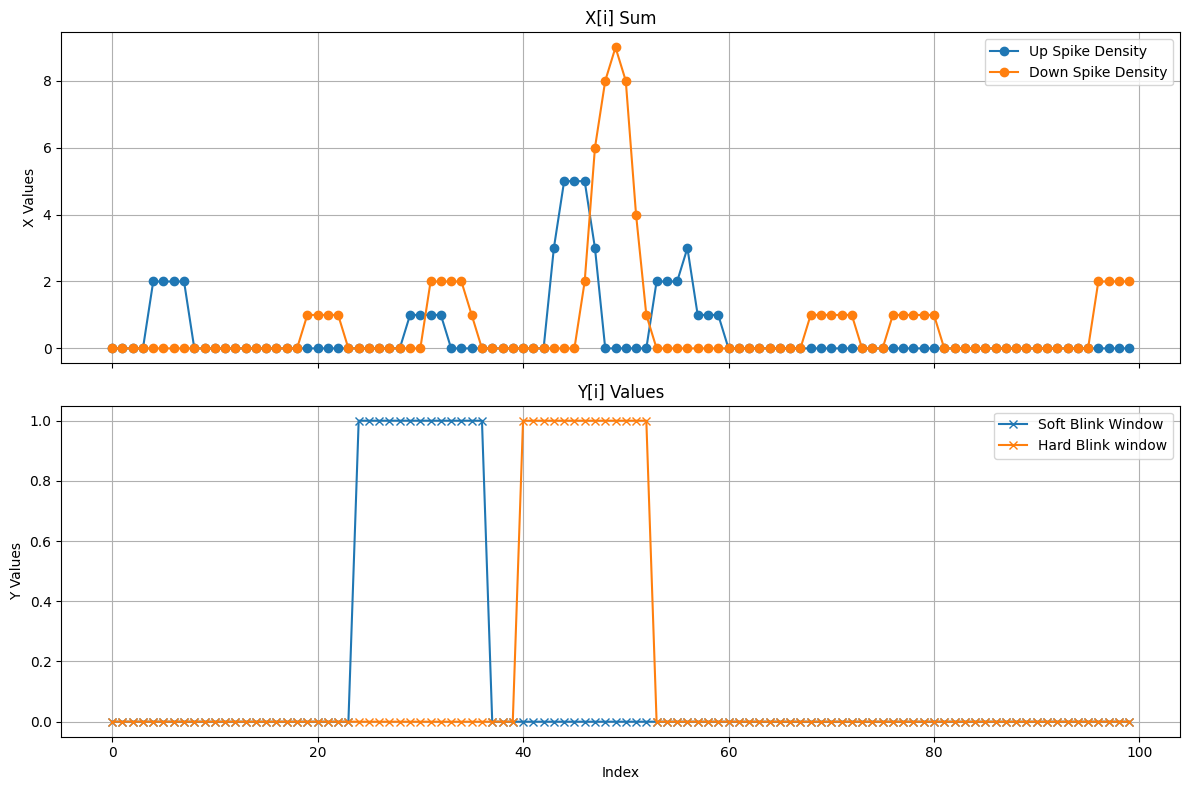

In [ ]:
RANGE = 100

for i in range(0, RANGE):
    X[i].sum(0).tolist()
    y[i].tolist()
    print(X[i].sum(0).tolist(), y[i].tolist())
x_range = range(RANGE)
x_sums = [X[i].sum(0).tolist() for i in x_range]
y_values = [y[i].tolist() for i in x_range]

x_col1 = [x[0] for x in x_sums]
x_col2 = [x[1] for x in x_sums]
y_col1 = [1 if y == 0 else 0 for y in y_values]  # Soft blink (mapped from 0)
y_col2 = [1 if y == 1 else 0 for y in y_values]  # Hard blink (mapped from 1)

fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot X values
axs[0].plot(x_range, x_col1, label="Up Spike Density", marker='o')
axs[0].plot(x_range, x_col2, label="Down Spike Density", marker='o')
axs[0].set_ylabel("X Values")
axs[0].set_title("X[i] Sum")
axs[0].legend()
axs[0].grid()

# Plot Y values
axs[1].plot(x_range, y_col1, label="Soft Blink Window", marker='x')
axs[1].plot(x_range, y_col2, label="Hard Blink window", marker='x')
axs[1].set_xlabel("Index")
axs[1].set_ylabel("Y Values")
axs[1].set_title("Y[i] Values")
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

### Dataset & balanced sampler

In [ ]:
class BlinkDS(Dataset):
    def __init__(self, X, y): self.X, self.y = X, y
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

# 80 / 20 split
perm = torch.randperm(len(X))
split = int(0.8*len(X))
train_idx, test_idx = perm[:split], perm[split:]
ds_tr, ds_te = BlinkDS(X[train_idx], y[train_idx]), BlinkDS(X[test_idx], y[test_idx])
# print(ds_tr.y.shape)
# balance the positives
is_soft = ds_tr.y==0 ; is_hard = ds_tr.y==1
w_soft  = 0.25 / is_soft.sum()
w_hard  = 0.25 / is_hard.sum()
w_none  = 0.50 / (len(ds_tr)-is_soft.sum()-is_hard.sum())

weights = torch.where(is_soft, w_soft, torch.where(is_hard, w_hard, w_none))
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

ldr_tr = DataLoader(ds_tr, batch_size=BATCH, sampler=sampler)
ldr_te = DataLoader(ds_te, batch_size=BATCH, shuffle=False)
print("Soft weights:", w_soft.item())
print("Hard weights:", w_hard.item())
print("None weights:", w_none.item())

Soft weights: 0.00390625
Hard weights: 0.0028409091755747795
None weights: 0.0009469697251915932


####  Build the 2-4-4-2 Izh network

In [ ]:
def gen_seq_model(topo, neuron_layer, neuron_params={}, bias=False, quant_weights=False, quant_states=False):
    state_quant = SF.quant.state_quant(num_bits=8, uniform=True, thr_centered=False) if quant_states else None
    layers = []

    neuron_layer_classes = {
        'NormIzh': snn.NormIzh,
        'Leaky': snn.Leaky,
    }

    if neuron_layer not in neuron_layer_classes:
        raise ValueError(f"Invalid neuron_layer '{neuron_layer}'. Available options: {list(neuron_layer_classes.keys())}")

    neuron_class = neuron_layer_classes[neuron_layer]

    for i in range(len(topo) - 1):
        if quant_weights:
            layers.append(qnn.QuantLinear(
                topo[i], topo[i + 1], bias=bias,
                weight_quant=brevitas.quant.Int8WeightPerTensorFixedPoint, weight_bit_width=4))
        else:
            layers.append(nn.Linear(topo[i], topo[i + 1], bias=bias))

        if i < len(topo) - 2:
            layers.append(neuron_class(init_hidden=True, state_quant=state_quant, **neuron_params))

    layers.append(neuron_class(init_hidden=True, output=True, state_quant=state_quant, **neuron_params))

    return nn.Sequential(*layers)

In [ ]:
topo = [2, 4, 4, 2]                          # ← requested topology
model = gen_seq_model(
    topo=topo,
    neuron_layer='NormIzh',
    neuron_params={'neuron_type': 'RS'},
    bias=True,
    quant_weights=False,
    quant_states=False,
).to(device)
# model = snn.gen_seq_model(
#             topo,
#             neuron_layer="NormIzh",
#             neuron_params={"neuron_type":"RS"},
#             bias=True).to(device)

# Surrogate gradient already built-in to NormIzh


Added NormIzh() to instances: [NormIzh(), NormIzh(), NormIzh(), NormIzh(), NormIzh(), NormIzh(), NormIzh(), NormIzh(), NormIzh(), NormIzh(), NormIzh(), NormIzh(), NormIzh(), NormIzh(), NormIzh(), NormIzh()].
Added NormIzh() to instances: [NormIzh(), NormIzh(), NormIzh(), NormIzh(), NormIzh(), NormIzh(), NormIzh(), NormIzh(), NormIzh(), NormIzh(), NormIzh(), NormIzh(), NormIzh(), NormIzh(), NormIzh(), NormIzh(), NormIzh()].
Added NormIzh() to instances: [NormIzh(), NormIzh(), NormIzh(), NormIzh(), NormIzh(), NormIzh(), NormIzh(), NormIzh(), NormIzh(), NormIzh(), NormIzh(), NormIzh(), NormIzh(), NormIzh(), NormIzh(), NormIzh(), NormIzh(), NormIzh()].


### Loss, optimiser, imbalance weights

In [ ]:
num_soft = int((ds_tr.y == 0).sum())  # Count occurrences of class 0 (soft blinks)
num_hard = int((ds_tr.y == 1).sum())  # Count occurrences of class 1 (hard blinks)
pos_w    = torch.tensor([len(ds_tr)/num_soft,
                         len(ds_tr)/num_hard], device=device)
loss_fn  = torch.nn.CrossEntropyLoss(weight=pos_w)  # Use CrossEntropyLoss for multi-class classification
opt      = torch.optim.Adam(model.parameters(), lr=LR)


In [ ]:
class_weights = torch.tensor([1.0, 1.0, 1.0], device=device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
for i in range(10):
    print("up/down counts :", X[i].sum(0).tolist(), " target :", y[i].tolist())

up/down counts : [0.0, 0.0]  target : 2
up/down counts : [0.0, 0.0]  target : 2
up/down counts : [0.0, 0.0]  target : 2
up/down counts : [0.0, 0.0]  target : 2
up/down counts : [2.0, 0.0]  target : 2
up/down counts : [2.0, 0.0]  target : 2
up/down counts : [2.0, 0.0]  target : 2
up/down counts : [2.0, 0.0]  target : 2
up/down counts : [0.0, 0.0]  target : 2
up/down counts : [0.0, 0.0]  target : 2


## Training loop

RuntimeError: weight tensor should be defined either for all 2 classes or no classes but got weight tensor of shape: [3]

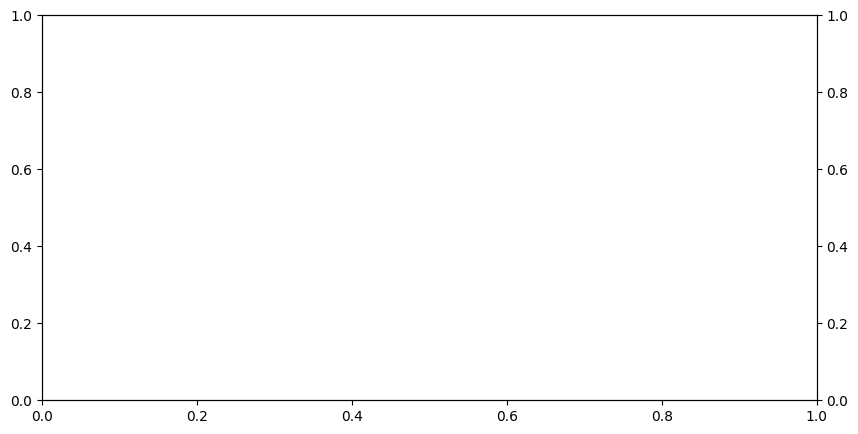

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

plt.ion()
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()  # Create a second y-axis

train_losses = []
val_accuracies = []
val_confidences = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    for Xb, yb in ldr_tr:
        Xb = Xb.to(device)
        yb = yb.to(device)
        utils.reset(model)
        spk = []
        for t in range(Xb.size(1)):
            out, *_ = model(Xb[:,t,:])
            spk.append(out)
        logits = torch.stack(spk).sum(0)
        bce  = loss_fn(logits, yb.float())
        l1   = 1e-4 * logits.abs().mean()
        loss = bce + l1
        opt.zero_grad(); loss.backward();
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(ldr_tr))

    # Validation
    model.eval(); corr = tot = 0
    confidences = []
    with torch.no_grad():
        for Xb, yb in ldr_te:
            Xb = Xb.to(device)
            utils.reset(model)
            spk = []
            for t in range(Xb.size(1)):
                o, *_ = model(Xb[:,t,:])
                spk.append(o)
            logits = torch.stack(spk).sum(0)
            probs = torch.sigmoid(logits)
            # preds = (probs > THRESH_PROB).float()
            # corr += (preds == yb.to(device)).all(1).sum().item()
            # instead of threshold on sigmoid, just pick the larger spike‐count:
            preds = torch.argmax(logits, dim=1)             # → 0 = soft, 1 = hard
            labels = yb.argmax(dim=1).to(device)
            corr += (preds == labels).sum().item()
            tot += len(Xb)
            confidences.extend(probs.max(dim=1)[0].cpu().numpy())
    val_accuracies.append(corr / tot)
    val_confidences.append(np.mean(confidences))
    
    # Live plot update
    clear_output(wait=True)
    ax1.cla()
    ax2.cla()
    epochs = range(1, len(train_losses) + 1)
    # Plot loss on left y-axis
    ax1.plot(epochs, train_losses, label="Loss", color='red')
    ax1.set_ylabel("Loss", color='red')
    ax1.tick_params(axis='y', labelcolor='red')
    ax1.set_xlabel("Epochs")
    ax1.set_ylim(0, max(train_losses) * 1.1)
    # Plot accuracy and confidence on right y-axis
    ax2.plot(epochs, val_accuracies, label="Accuracy", color='blue')
    ax2.plot(epochs, val_confidences, label="Confidence", color='green')
    ax2.set_ylabel("Accuracy & Confidence", color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')
    # Legends
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
    ax1.set_title("Training Progress")
    ax1.grid(True)
    plt.tight_layout()
    display(fig)
    plt.pause(0.01)
    print(f"Epoch {epoch:2d}  val-exact-acc  {corr/tot:.3f}")

plt.ioff()
plt.show()

### Test Report

In [ ]:
y_true, y_pred = [], []
model.eval(); torch.no_grad()
for Xb,yb in ldr_te:
    Xb = Xb.to(device)
    utils.reset(model); spk=[]
    for t in range(Xb.size(1)):
        o,*_ = model(Xb[:,t,:]); spk.append(o)
    logits = torch.stack(spk).sum(0)
    probs  = torch.sigmoid(logits)
    # preds  = (probs > THRESH_PROB).float()
    preds = (torch.sigmoid(logits) > THRESH_PROB).float()
    y_true.append(yb); y_pred.append(preds.cpu())

print(classification_report(torch.cat(y_true),
                            torch.cat(y_pred),
                            target_names=["soft", "hard"]))


### Inference on unseen data

In [ ]:
def predict_window(raw_up, raw_dn):
    up  = (raw_up > THR_VOLT).astype(np.float32)
    dn  = (raw_dn > THR_VOLT).astype(np.float32)
    x   = torch.from_numpy(np.stack([up,dn],1)).unsqueeze(0).to(device)

    utils.reset(model); spk=[]
    for t in range(x.size(1)):
        o,*_ = model(x[:,t,:]); spk.append(o)
    logits = torch.stack(spk).sum(0)
    probs  = torch.sigmoid(logits)[0]
    if probs.max() < THRESH_PROB:
        return "no-blink"
    return "soft" if probs[0] > probs[1] else "hard"
